In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb


import warnings
warnings.filterwarnings("ignore")

/home/anson/.local/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Theoretical $q^2$

In [2]:
def dGammaDsmu(q2):
    return 1.08656*10**(-6) * (1 - 0.011025/q2)**2 *np.sqrt((11.5532 - q2) * (53.8022 - q2)) * q2 * (3.10955/(q2**2 * (1 - 0.058671 * q2 + 0.000940087 * q2**2)**2) + (0.3025 * (1 + 0.0055125/q2) * (11.5532 - q2) * (53.8022 - q2))/(q2 * (1 - 0.0847084 * q2 + 0.00204891 * q2**2)**2))

def dGammaDstau(q2):
    return 1.08656*10**(-6) * (1 - 3.16128/q2)**2 *np.sqrt((11.5532 - q2) * (53.8022 - q2)) * q2 * (891.626/(q2**2 * (1 - 0.058671 * q2 + 0.000940087 * q2**2)**2) + (0.3025 * (1 + 1.58064/q2) * (11.5532 - q2) * (53.8022 - q2))/(q2 * (1 - 0.0847084 * q2 + 0.00204891 * q2**2)**2))

def dGammaDsstarmu(q2):
    return 1.08656*10**(-6) * (1 - 0.011025/q2)**2 * np.sqrt((10.595 - q2) * (55.9354 - q2)) * q2 *\
            ((0.00365313 * (10.595 - q2) * (55.9354 - q2))/(q2**2 * (1 - 0.0864443 * q2 + 0.00209712 * q2**2)**2) + (1 + 0.0055125/q2) * ((3.66471/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) - (0.0828988 *np.sqrt((10.595 - q2) * (55.9354 - q2)))/(1 - 0.0860971 * q2 + 0.0020007 * q2**2))**2 + \
            (3.66471/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) + (0.0828988 * np.sqrt((10.595 - q2) * (55.9354 - q2)))/(1 - 0.0860971 * q2 + 0.0020007 * q2**2))**2 + (3.13501 * ((0.49 * (-24.3441 + q2))/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) + (0.00929643 * (10.595 - q2) * (55.9354 - q2))/(1 - 0.0808896 * q2 + 0.00218148 * q2**2))**2)/q2))

def dGammaDsstartau(q2):
    return 1.08656*10**(-6) * (1 - 3.16128/q2)**2 * np.sqrt((10.595 - q2) * (55.9354 - q2)) * q2 *\
            ((1.04749 * (10.595 - q2) * (55.9354 - q2))/(q2**2 * (1 - 0.0864443 * q2 + 0.00209712 * q2**2)**2) + (1 + 1.58064/q2) * ((3.66471/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) - (0.0828988 *np.sqrt((10.595 - q2) * (55.9354 - q2)))/(1 - 0.0860971 * q2 + 0.0020007 * q2**2))**2 + \
            (3.66471/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) + (0.0828988 *np.sqrt((10.595 - q2) * (55.9354 - q2)))/(1 - 0.0860971 * q2 + 0.0020007 * q2**2))**2 + (3.13501 * ((0.49 * (-24.3441 + q2))/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) + (0.00929643 * (10.595 - q2) * (55.9354 - q2))/(1 - 0.0808896 * q2 + 0.00218148 * q2**2))**2)/q2))



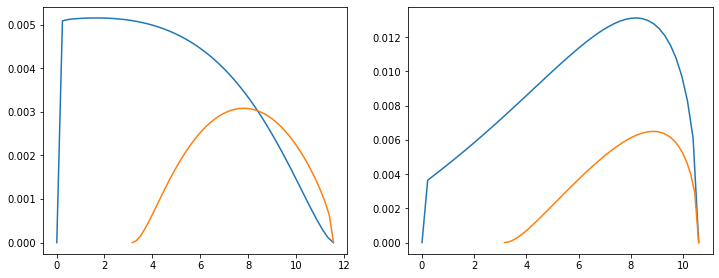

In [3]:
q2_mu = np.linspace(0.105**2, 11.5532)
q2_tau = np.linspace(1.778**2, 11.5532)
q2_star_mu = np.linspace(0.105**2, 10.595)
q2_star_tau = np.linspace(1.778**2, 10.595)

plt.figure(figsize=(12,10))
dGmu = dGammaDsmu(q2_mu)
dGtau = dGammaDstau(q2_tau)
dGstarmu = dGammaDsstarmu(q2_star_mu)
dGstartau = dGammaDsstartau(q2_star_tau)

ax1 = plt.subplot(221)
ax1.plot(q2_mu, dGmu)
ax1.plot(q2_tau, dGtau)

ax2 = plt.subplot(222)
ax2.plot(q2_star_mu, dGstarmu)
ax2.plot(q2_star_tau, dGstartau)

## Loading Data

In [4]:
epsilon_pimu = 1/100


modes_dt = {0: {'mode': './features/IDEA_card_DsTauNu_10Noise.root', 'yields': 5.14e5}, 
            1: {'mode': './features/IDEA_card_DsMuNu_10Noise.root', 'yields': 8.80e6},
            2: {'mode': './features/IDEA_card_DsstarTauNu_10Noise.root', 'yields': 8.16e5}, 
            3: {'mode': './features/IDEA_card_DsstarMuNu_10Noise.root', 'yields': 1.86e7},
            4: {'mode': './features/RDsInclusive_10Noise.root', 'yields': 2.78e6},
            5: {'mode': './features/RDsCombCascade_10Noise.root', 'yields': 8.55e6},
            6: {'mode': './features/RDsMisID_10Noise.root', 'yields': epsilon_pimu*8.51e7}
           }

# # 20noise
# modes_dt = {0: {'mode': './features/IDEA_card_TauNu_20Noise.root', 'yields': 5.15e5}, 
#             1: {'mode': './features/IDEA_card_MuNu_20Noise.root', 'yields': 8.79e6},
#             2: {'mode': './features/IDEA_card_starTauNu_20Noise.root', 'yields': 8.14e5}, 
#             3: {'mode': './features/IDEA_card_starMuNu_20Noise.root', 'yields': 1.85e7},
#             4: {'mode': './features/RDsInclusive_20Noise.root', 'yields': 2.76e6},
#             5: {'mode': './features/RDsCombCascade_20Noise.root', 'yields': 9.87e6},
#             6: {'mode': './features/RDsMisID_20Noise.root', 'yields': epsilon_pimu*9.90e7}
#            }

In [5]:
def load_train_test(modes_dt, size=0.5):
    np.random.seed(9)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    num_lt = []
    
    # loop over different modes
    for i, (k, v) in enumerate(modes_dt.items()):
        file = uproot.open(v['mode'])
#         df_i = file['t'].pandas.df() 
        df_i = pd.DataFrame(np.array(file['t']['features'].array()))   
        df_i['target'] = i    # add the target label
        df_i['weight'] = v['yields']/len(df_i)
        num_lt.append(len(df_i))

        # shuffle the index for training and testing sets
        idx = df_i.index.tolist()
        np.random.shuffle(idx)
        
        # cut according to the fraction
        cut = int(np.ceil(len(idx) * size))
        df_train_i = df_i.loc[idx[:cut]]
        df_test_i = df_i.loc[idx[cut:]]
        
        # Put to the global dataframs
        df_train = pd.concat([df_train, df_train_i])
        df_test = pd.concat([df_test, df_test_i])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    print('train size: {} ({:.2f}%); test size: {} ({:.2f}%)'.format(len(df_train), 100*len(df_train)/(len(df_train)+len(df_test)), len(df_test), 100*len(df_test)/(len(df_train)+len(df_test))))
    print('data points per mode: ',num_lt)
    return df_train, df_test

    

In [6]:
tr_te_split = 0.5
df_train, df_test = load_train_test(modes_dt, tr_te_split)
# df_test, df_train = load_train_test(modes_dt, tr_te_split)
# make a copy
df_train_o, df_test_o = df_train.copy(), df_test.copy()

train size: 49704 (50.00%); test size: 49699 (50.00%)
data points per mode:  [1555, 10094, 849, 2647, 2374, 7623, 74261]


In [7]:
def relabel(x):
    if x == 0 :    # Ds tau signal
        return 0
    elif x == 1:     # Ds mu signal
        return 1
    if x == 2 :    # Ds* tau signal
        return 2
    elif x == 3:     # Ds* mu signal
        return 3
    else:         # Bkg.
        return 4
    

In [8]:
# relabel the, all bkg become one label
df_train['target'] = df_train['target'].apply(relabel)
df_test['target'] = df_test['target'].apply(relabel)

In [9]:
df_train.columns

Index(['iEvt', 'q2', 'miss2', 'pB', 'EB', 'pHc', 'EHc', 'pMu', 'EMu',
       'sMinMuBVert', 'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc', 'mHcMu',
       'pPerp', 'mCorr', 'D0Max', 'DzMax', 'D0Sum', 'DzSum', 'ENeutral03',
       'ENeutral06', 'ENeutral03Hadron', 'ENeutral06Hadron',
       'ENeutral03Photon', 'ENeutral06Photon', 'ECharge03', 'ECharge06',
       'ECharge03PV', 'ECharge06PV', 'ECharge03DV', 'ECharge06DV', 'mK0SHcMu',
       'pK0S', 'DeltaM', 'q2True', 'miss2True', 'EBTrue', 'pBTrue',
       'sMinMuHcVertTrue', 'correctPhoton', 'EPhoTrue', 'isDsPho',
       'DeltaRDsPhoTrue', 'target', 'weight'],
      dtype='object')

In [10]:
# features = ['q2', 'miss2', 
#             'pB', 'EB', 
#             'pHc', 'EHc', 
#             'pMu', 'EMu',
#             'sMinMuBVert', 'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc', 
#             'mHcMu',
#             'pPerp', 'mCorr', 
#             'D0Max', 'DzMax', 'D0Sum', 'DzSum', 
#             'ENeutral03','ENeutral06', 
#             'ENeutral03Hadron', 'ENeutral06Hadron',
#             'ENeutral03Photon', 'ENeutral06Photon', 
#             'ECharge03', 'ECharge06',
#             'ECharge03PV', 'ECharge06PV', 
#             'ECharge03DV', 'ECharge06DV', 
#             'mK0SHcMu', 'pK0S', 
#             'DeltaM'
#            ]

features = ['q2', 'miss2', 
            'pB', 'EB', 
            'pHc', 'EHc', 
            'pMu', 'EMu',
            'sMinMuBVert', 'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc', 
            'mHcMu',
            'pPerp', 'mCorr', 
            'D0Max', 'DzMax', 'D0Sum', 'DzSum', 
            'ENeutral03','ENeutral06', 
            'ENeutral03Hadron', 'ENeutral06Hadron',
            'ENeutral03Photon', 'ENeutral06Photon', 
            'ECharge03', 'ECharge06',
            'ECharge03PV', 'ECharge06PV', 
            'ECharge03DV', 'ECharge06DV', 
            'DeltaM'
           ]

In [11]:
df_train[features] = df_train[features].replace([99999, -np.inf, np.inf], np.nan)
df_test[features] = df_test[features].replace([99999, -np.inf, np.inf], np.nan)

## Reweight by $q^2
$

In [12]:
df_train_o[df_train_o.target==2].q2True.max(), df_train_o[df_train_o.target==3].q2True.min()

(11.378799, 0.075047046)

In [13]:
# replace some values that have q2 larger than the max, by the max
df_train_o.loc[(df_train_o['q2True']>=10.595) & ((df_train_o.target==2) | (df_train_o.target==3)), 'q2True'] = 10.594
df_train.loc[(df_train['q2True']>=10.595) & ((df_train.target==2) | (df_train.target==3)), 'q2True'] = 10.594
df_test.loc[(df_test['q2True']>=10.595) & ((df_test.target==2) | (df_test.target==3)), 'q2True'] = 10.594

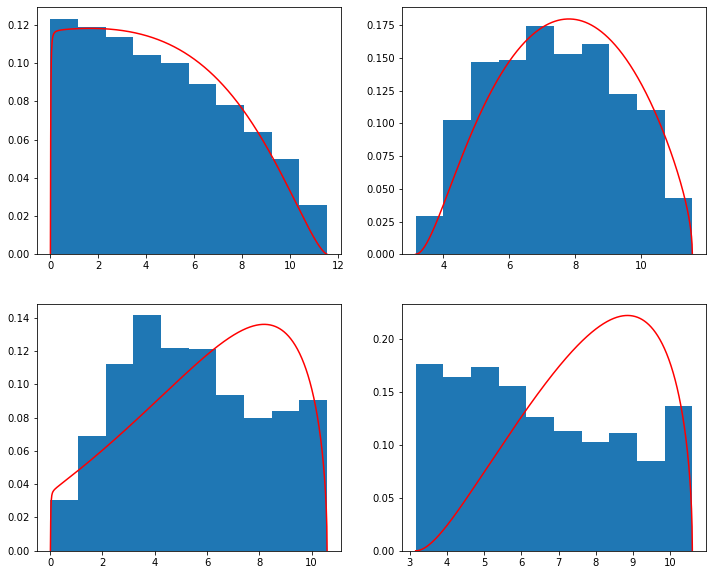

In [14]:
bins = 10

plt.figure(figsize=(12, 10))

# plot for mu
ax1 = plt.subplot(221)
range_mu = [0.105**2, 11.5532]
ax1.hist(df_train_o[df_train_o.target==1]['q2True'], bins=bins, density=True, range=range_mu);
q2_mu = np.linspace(range_mu[0], range_mu[1], 1000, endpoint=True)
dGmu = dGammaDsmu(q2_mu)
plt.plot(q2_mu, dGmu/np.trapz(dGmu, x=q2_mu), color='red', label='theoretical')

# # plot for tau
ax2 = plt.subplot(222)
range_tau = [1.778**2, 11.5532]
bins=10
ax2.hist(df_train_o[df_train_o.target==0]['q2True'], bins=bins, density=True, range=range_tau);
q2_tau = np.linspace(range_tau[0], range_tau[1], 1000, endpoint=True)
dGtau = dGammaDstau(q2_tau)
plt.plot(q2_tau, dGtau/np.trapz(dGtau, x=q2_tau), color='red', label='theoretical')

# plot for tau
ax3 = plt.subplot(223)
range_star_mu = [0.105**2, 10.594999]
ax3.hist(df_train_o[df_train_o.target==3]['q2True'], bins=bins, density=True, range=range_star_mu);
q2_star_mu = np.linspace(range_star_mu[0], range_star_mu[1], 1000, endpoint=True)
dGstarmu = dGammaDsstarmu(q2_star_mu)
plt.plot(q2_star_mu, dGstarmu/np.trapz(dGstarmu, x=q2_star_mu), color='red', label='theoretical')

# plot for mu
range_star_tau = [1.778**2, 10.594999]
ax4 = plt.subplot(224)
ax4.hist(df_train_o[df_train_o.target==3]['q2True'], bins=bins, density=True, range=range_star_tau);
q2_star_tau = np.linspace(range_star_tau[0], range_star_tau[1], 1000, endpoint=True)
dGstartau = dGammaDsstartau(q2_star_tau)
plt.plot(q2_star_tau, dGstartau/np.trapz(dGstartau, x=q2_star_tau), color='red', label='theoretical')

In [15]:
# reweight according to q^2
def find_m_rw(dGamma, df_train, target, range_, bin_num=10):
    # get the truth q2 array
    q2 = df_train[df_train.target==target]['q2True'].values    

    # Simulated bins
    hist, bins = np.histogram(a=q2, bins=bin_num, density=True, range=range_)
    width = np.diff(bins)
    center = (bins[:-1] + bins[1:]) / 2

    # Theoretical bins
    th_w = []
    for i in range(bin_num):
        dx = -(bins[i] - bins[i+1])/10
        x = np.linspace(bins[i], bins[i+1], 1000)
        y = dGamma(q2=x)
        th_w.append(np.trapz(y, dx=dx))    # Find area under curve
    # normalize
    th_w = th_w / sum(th_w) / width

    # reweighting
    m_rw = th_w / hist
    m_rw[np.isinf(m_rw)] = 0
    
    # return the values of each bin, and the bin bounds
    return m_rw, bins





# add the reweighting column to th dataframe
def add_m_rw(target, m_rw, bins, df):
    for i in range(len(bins)-1):
        df.loc[(df['target']==target) & (df['q2True']>=bins[i]) & (df['q2True']<bins[i+1]), 'm_rw'] = m_rw[i]
    
#     print(df.loc[df['target']==target, 'weight'].sum())
#     df.loc[df.target==target, 'm_rw'] = df.loc[df.target==target, 'm_rw']/(df.loc[df.target==target, 'm_rw'].sum())
    df.loc[df['target']==target, 'reweight'] = df.loc[df['target']==target, 'weight'] * df.loc[df.target==target, 'm_rw']
    df = df.drop(columns = ['m_rw'])
    
#     print(df.loc[df.target==target, 'reweight'].sum())
#     print()
    return df

In [16]:
# getting the weightings, and the bin bounds
m_rw_tau, bins_tau = find_m_rw(dGammaDstau, df_train_o, target=0, range_=range_tau)
m_rw_mu, bins_mu = find_m_rw(dGammaDsmu, df_train_o, target=1, range_=range_mu)
m_rw_star_tau, bins_star_tau = find_m_rw(dGammaDsstartau, df_train_o, target=2, range_=range_star_tau)
m_rw_star_mu, bins_star_mu = find_m_rw(dGammaDsstarmu, df_train_o, target=3, range_=range_star_mu)

# duplicate the column for inputting to the function to get the reweight column
df_train_o['reweight'] = df_train_o['weight']
df_train['reweight'] = df_train['weight']
df_test['reweight'] = df_test['weight']


df_train_o = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_train_o)
df_train_o = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_train_o)
df_train_o = add_m_rw(target=2, m_rw=m_rw_star_tau, bins=bins_star_tau, df=df_train_o)
df_train_o = add_m_rw(target=3, m_rw=m_rw_star_mu, bins=bins_star_mu, df=df_train_o)

df_train = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_train)
df_train = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_train)
df_train = add_m_rw(target=2, m_rw=m_rw_star_tau, bins=bins_star_tau, df=df_train)
df_train = add_m_rw(target=3, m_rw=m_rw_star_mu, bins=bins_star_mu, df=df_train)

df_test = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_test)
df_test = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_test)
df_test = add_m_rw(target=2, m_rw=m_rw_star_tau, bins=bins_star_tau, df=df_test)
df_test = add_m_rw(target=3, m_rw=m_rw_star_mu, bins=bins_star_mu, df=df_test)


In [17]:
m_rw_mu, m_rw_tau, m_rw_star_mu, m_rw_star_tau

(array([0.9375342 , 0.99129627, 1.03069835, 1.09475544, 1.08267463,
        1.10521819, 1.0742623 , 0.99548556, 0.75672708, 0.38973684]),
 array([0.50105325, 0.63431062, 0.7774281 , 1.01104065, 0.98345774,
        1.16994933, 1.07357057, 1.23704021, 1.04187871, 1.33802239]),
 array([1.33505926, 0.7954944 , 0.6203132 , 0.59975432, 0.82215207,
        0.95070045, 1.36973094, 1.69089474, 1.53756994, 0.95144623]),
 array([1.14767886, 1.67540218, 1.25234969, 0.82037544, 1.03772943,
        0.90641975, 1.06358269, 1.12631888, 1.20420594, 0.67709408]))

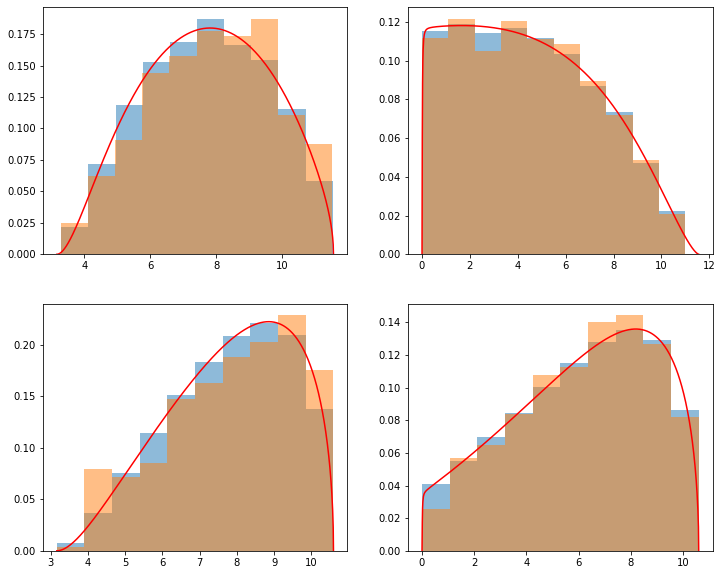

In [18]:
bins = 10

plt.figure(figsize=(12, 10))

# reweighted plot for tau, in testing 
ax1 = plt.subplot(221)
ax1.hist(df_train[df_train.target==0]['q2True'], bins=10, weights=df_train[df_train.target==0]['reweight'], density=True, alpha=0.5);
ax1.hist(df_test[df_test.target==0]['q2True'], bins=10, weights=df_test[df_test.target==0]['reweight'], density=True, alpha=0.5);
ax1.plot(q2_tau, dGtau/np.trapz(dGtau, x=q2_tau), color='red', label='theoretical')

# reweighted plot for mu, in testing 
ax2 = plt.subplot(222)
ax2.hist(df_train[df_train.target==1]['q2True'], bins=10, weights=df_train[df_train.target==1]['reweight'], density=True, alpha=0.5, range=[.105**2 ,11]);
ax2.hist(df_test[df_test.target==1]['q2True'], bins=10, weights=df_test[df_test.target==1]['reweight'], density=True, alpha=0.5, range=[.105**2 ,11]);
ax2.plot(q2_mu, dGmu/np.trapz(dGmu, x=q2_mu), color='red', label='theoretical')

ax3 = plt.subplot(223)
ax3.hist(df_train[df_train.target==2]['q2True'], bins=10, weights=df_train[df_train.target==2]['reweight'], density=True, alpha=0.5, range=range_star_tau);
ax3.hist(df_test[df_test.target==2]['q2True'], bins=10, weights=df_test[df_test.target==2]['reweight'], density=True, alpha=0.5, range=range_star_tau);
ax3.plot(q2_star_tau, dGstartau/np.trapz(dGstartau, x=q2_star_tau), color='red', label='theoretical')

ax4 = plt.subplot(224)
ax4.hist(df_train[df_train.target==3]['q2True'], bins=10, weights=df_train[df_train.target==3]['reweight'], density=True, alpha=0.5, range=range_star_mu);
ax4.hist(df_test[df_test.target==3]['q2True'], bins=10, weights=df_test[df_test.target==3]['reweight'], density=True, alpha=0.5, range=range_star_mu);
ax4.plot(q2_star_mu, dGstarmu/np.trapz(dGstarmu, x=q2_star_mu), color='red', label='theoretical')

## Saving Plots

In [19]:
df_plot = df_test

In [20]:
# f = plt.figure(figsize=(8,6))
# ax1 = plt.subplot(111)
# range_=[0,45]

# ax1.margins(y=0.3)


# ax1.hist(df_plot[(df_plot.target==0)]['EB'], weights=df_plot[df_plot.target==0]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5, color='C0');
# ax1.hist(df_plot[(df_plot.target==1)]['EB'], weights=df_plot[df_plot.target==1]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5, color='C1');
# ax1.hist(df_plot[(df_plot.target==2)]['EB'], weights=df_plot[df_plot.target==2]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C2');
# ax1.hist(df_plot[(df_plot.target==3)]['EB'], weights=df_plot[df_plot.target==3]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C3');
# ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['EB'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C4');

# ax1.legend(loc=2, fontsize=20)
# ax1.hist(df_plot[(df_plot.target==0)]['EBTrue'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
# ax1.hist(df_plot[(df_plot.target==1)]['EBTrue'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');
# ax1.hist(df_plot[(df_plot.target==2)]['EBTrue'], weights=df_plot[df_plot.target==2]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
# ax1.hist(df_plot[(df_plot.target==3)]['EBTrue'], weights=df_plot[df_plot.target==3]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

# ax1.set_ylabel('Normlized distribution', fontsize=20)
# ax1.set_xlabel(r'$E_{D_s^0}$ [GeV]', fontsize=20)
# ax1.set_yticks([])

X_mea0 = df_plot[(df_plot.target==0)]['EB']
X_mea1 = df_plot[(df_plot.target==1)]['EB']
X_mea2 = df_plot[(df_plot.target==2)]['EB']
X_mea3 = df_plot[(df_plot.target==3)]['EB']
X_tru0 = df_plot[(df_plot.target==0)]['EBTrue']
X_tru1 = df_plot[(df_plot.target==1)]['EBTrue']
X_tru2 = df_plot[(df_plot.target==2)]['EBTrue']
X_tru3 = df_plot[(df_plot.target==3)]['EBTrue']

X0 = X_mea0 - X_tru0
X1 = X_mea1 - X_tru1
X2 = X_mea2 - X_tru2
X3 = X_mea3 - X_tru3

W0 = df_plot[(df_plot.target==0)]['reweight']
W1 = df_plot[(df_plot.target==1)]['reweight']
W2 = df_plot[(df_plot.target==2)]['reweight']
W3 = df_plot[(df_plot.target==3)]['reweight']

X_Wmean0 = sum(X0 * W0) / sum(W0)
X_Wmean1 = sum(X1 * W1) / sum(W1)
X_Wmean2 = sum(X2 * W2) / sum(W2)
X_Wmean3 = sum(X3 * W3) / sum(W3)

print("E_B")
print("error for Ds tau mode: {:.2f}".format((sum((X0 - X_Wmean0)**2 * W0) / (sum(W0)*(len(W0)-1)/len(W0)))**0.5))
print("error for Ds mu mode:  {:.2f}".format((sum((X1 - X_Wmean1)**2 * W1) / (sum(W1)*(len(W1)-1)/len(W1)))**0.5))
print("error for Ds* tau mode: {:.2f}".format((sum((X2 - X_Wmean2)**2 * W2) / (sum(W2)*(len(W2)-1)/len(W2)))**0.5))
print("error for Ds* mu mode:  {:.2f}".format((sum((X3 - X_Wmean3)**2 * W3) / (sum(W3)*(len(W3)-1)/len(W3)))**0.5))

# f.savefig('./figures/DsEB')
# f.savefig('./figures/DsEB_20noise')



E_B
error for Ds tau mode: 1.46
error for Ds mu mode:  1.70
error for Ds* tau mode: 1.82
error for Ds* mu mode:  1.82


In [21]:
# f = plt.figure(figsize=(8,6))
# ax1 = plt.subplot(111)
# range_=[-6,12]
# bins_=20
# ax1.margins(y=0.4)


# ax1.hist(df_plot[(df_plot.target==0)]['q2'], weights=df_plot[df_plot.target==0]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5, color='C0');
# ax1.hist(df_plot[(df_plot.target==1)]['q2'], weights=df_plot[df_plot.target==1]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5, color='C1');
# ax1.hist(df_plot[(df_plot.target==2)]['q2'], weights=df_plot[df_plot.target==2]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C2');
# ax1.hist(df_plot[(df_plot.target==3)]['q2'], weights=df_plot[df_plot.target==3]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C3');
# ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['q2'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C4');

# ax1.legend(loc=2, fontsize=20)
# ax1.hist(df_plot[(df_plot.target==0)]['q2True'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
# ax1.hist(df_plot[(df_plot.target==1)]['q2True'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');
# ax1.hist(df_plot[(df_plot.target==2)]['q2True'], weights=df_plot[df_plot.target==2]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
# ax1.hist(df_plot[(df_plot.target==3)]['q2True'], weights=df_plot[df_plot.target==3]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

# ax1.set_ylabel('Normlized distribution', fontsize=20)
# ax1.set_xlabel(r'$q^2$ [GeV$^2$]', fontsize=20)
# ax1.set_yticks([])


X_mea0 = df_plot[(df_plot.target==0)]['q2']
X_mea1 = df_plot[(df_plot.target==1)]['q2']
X_mea2 = df_plot[(df_plot.target==2)]['q2']
X_mea3 = df_plot[(df_plot.target==3)]['q2']
X_tru0 = df_plot[(df_plot.target==0)]['q2True']
X_tru1 = df_plot[(df_plot.target==1)]['q2True']
X_tru2 = df_plot[(df_plot.target==2)]['q2True']
X_tru3 = df_plot[(df_plot.target==3)]['q2True']

X0 = X_mea0 - X_tru0
X1 = X_mea1 - X_tru1
X2 = X_mea2 - X_tru2
X3 = X_mea3 - X_tru3

W0 = df_plot[(df_plot.target==0)]['reweight']
W1 = df_plot[(df_plot.target==1)]['reweight']
W2 = df_plot[(df_plot.target==2)]['reweight']
W3 = df_plot[(df_plot.target==3)]['reweight']

X_Wmean0 = sum(X0 * W0) / sum(W0)
X_Wmean1 = sum(X1 * W1) / sum(W1)
X_Wmean2 = sum(X2 * W2) / sum(W2)
X_Wmean3 = sum(X3 * W3) / sum(W3)

print("q2")
print("error for Ds tau mode: {:.2f}".format((sum((X0 - X_Wmean0)**2 * W0) / (sum(W0)*(len(W0)-1)/len(W0)))**0.5))
print("error for Ds mu mode:  {:.2f}".format((sum((X1 - X_Wmean1)**2 * W1) / (sum(W1)*(len(W1)-1)/len(W1)))**0.5))
print("error for Ds* tau mode: {:.2f}".format((sum((X2 - X_Wmean2)**2 * W2) / (sum(W2)*(len(W2)-1)/len(W2)))**0.5))
print("error for Ds* mu mode:  {:.2f}".format((sum((X3 - X_Wmean3)**2 * W3) / (sum(W3)*(len(W3)-1)/len(W3)))**0.5))

# f.savefig('./figures/Dsq2')
# f.savefig('./figures/Dsq2_20noise')

q2
error for Ds tau mode: 1.40
error for Ds mu mode:  1.22
error for Ds* tau mode: 1.57
error for Ds* mu mode:  1.10


In [22]:
# f = plt.figure(figsize=(8,6))
# ax1 = plt.subplot(111)
# range_=[-6,10]

# # ax1.margins(y=0.3)


# ax1.hist(df_plot[(df_plot.target==0)]['miss2'], weights=df_plot[df_plot.target==0]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5, color='C0');
# ax1.hist(df_plot[(df_plot.target==1)]['miss2'], weights=df_plot[df_plot.target==1]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5, color='C1');
# ax1.hist(df_plot[(df_plot.target==2)]['miss2'], weights=df_plot[df_plot.target==2]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C2');
# ax1.hist(df_plot[(df_plot.target==3)]['miss2'], weights=df_plot[df_plot.target==3]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C3');
# ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['miss2'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C4');

# ax1.legend(loc=1, fontsize=20)
# ax1.hist(df_plot[(df_plot.target==0)]['miss2True'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
# ax1.hist(df_plot[(df_plot.target==1)]['miss2True'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');
# ax1.hist(df_plot[(df_plot.target==2)]['miss2True'], weights=df_plot[df_plot.target==2]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
# ax1.hist(df_plot[(df_plot.target==3)]['miss2True'], weights=df_plot[df_plot.target==3]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

# ax1.set_ylabel('Normlized distribution', fontsize=20)
# ax1.set_xlabel(r'$m_{\rm miss}^2$ [GeV$^2$]', fontsize=20)
# ax1.set_yticks([])

X_mea0 = df_plot[(df_plot.target==0)]['miss2']
X_mea1 = df_plot[(df_plot.target==1)]['miss2']
X_mea2 = df_plot[(df_plot.target==2)]['miss2']
X_mea3 = df_plot[(df_plot.target==3)]['miss2']
X_tru0 = df_plot[(df_plot.target==0)]['miss2True']
X_tru1 = df_plot[(df_plot.target==1)]['miss2True']
X_tru2 = df_plot[(df_plot.target==2)]['miss2True']
X_tru3 = df_plot[(df_plot.target==3)]['miss2True']

X0 = X_mea0 - X_tru0
X1 = X_mea1 - X_tru1
X2 = X_mea2 - X_tru2
X3 = X_mea3 - X_tru3

W0 = df_plot[(df_plot.target==0)]['reweight']
W1 = df_plot[(df_plot.target==1)]['reweight']
W2 = df_plot[(df_plot.target==2)]['reweight']
W3 = df_plot[(df_plot.target==3)]['reweight']

X_Wmean0 = sum(X0 * W0) / sum(W0)
X_Wmean1 = sum(X1 * W1) / sum(W1)
X_Wmean2 = sum(X2 * W2) / sum(W2)
X_Wmean3 = sum(X3 * W3) / sum(W3)

print("miss2")
print("error for Ds tau mode: {:.2f}".format((sum((X0 - X_Wmean0)**2 * W0) / (sum(W0)*(len(W0)-1)/len(W0)))**0.5))
print("error for Ds mu mode:  {:.2f}".format((sum((X1 - X_Wmean1)**2 * W1) / (sum(W1)*(len(W1)-1)/len(W1)))**0.5))
print("error for Ds* tau mode: {:.2f}".format((sum((X2 - X_Wmean2)**2 * W2) / (sum(W2)*(len(W2)-1)/len(W2)))**0.5))
print("error for Ds* mu mode:  {:.2f}".format((sum((X3 - X_Wmean3)**2 * W3) / (sum(W3)*(len(W3)-1)/len(W3)))**0.5))

# f.savefig('./figures/Dsmiss2')
# f.savefig('./figures/Dsmiss2_20noise')


miss2
error for Ds tau mode: 1.63
error for Ds mu mode:  1.65
error for Ds* tau mode: 1.78
error for Ds* mu mode:  1.38


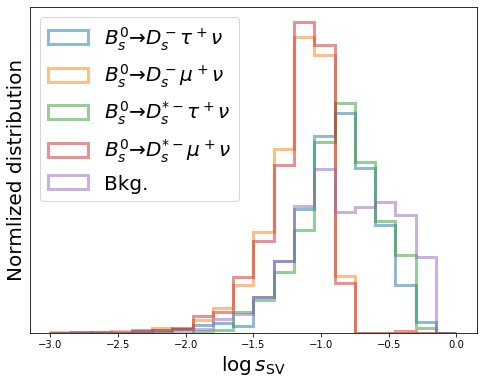

In [156]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-3,0]


ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuBVert']), weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuBVert']), weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==2)]['sMinMuBVert']), weights=df_plot[df_plot.target==2]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==3)]['sMinMuBVert']), weights=df_plot[df_plot.target==3]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['sMinMuBVert']), weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);

ax1.legend(loc=2, fontsize=20)
# ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, alpha=0.5, color='C0', linestyle='--');
# ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$\log{s_{\rm SV}}$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=2, fontsize=20)

f.savefig('./figures/Dslogssv')
# f.savefig('./figures/Dslogssv_20noise')



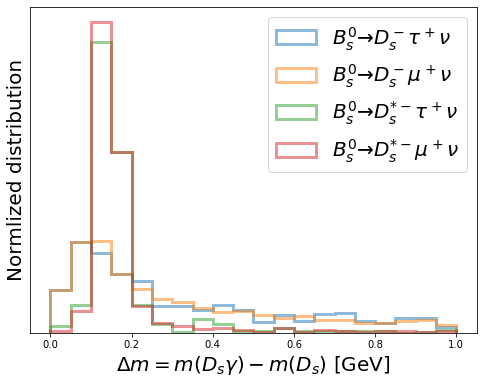

In [157]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,1]


ax1.hist(df_plot[(df_plot.target==0)]['DeltaM'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['DeltaM'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==2)]['DeltaM'], weights=df_plot[df_plot.target==2]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==3)]['DeltaM'], weights=df_plot[df_plot.target==3]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
# ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['DeltaM'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$\Delta m=m(D_s\gamma)-m(D_s)$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

f.savefig('./figures/Dsdeltam')
# f.savefig('./figures/Dsdeltam_20noise')


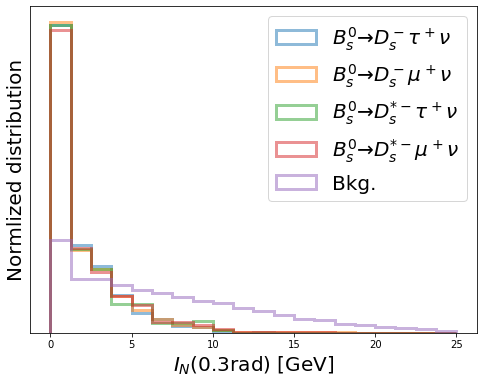

In [167]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,25]


ax1.hist(df_plot[(df_plot.target==0)]['ENeutral03'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['ENeutral03'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==2)]['ENeutral03'], weights=df_plot[df_plot.target==2]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==3)]['ENeutral03'], weights=df_plot[df_plot.target==3]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['ENeutral03'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$I_N(0.3\rm rad)$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

f.savefig('./figures/Dsisolation')


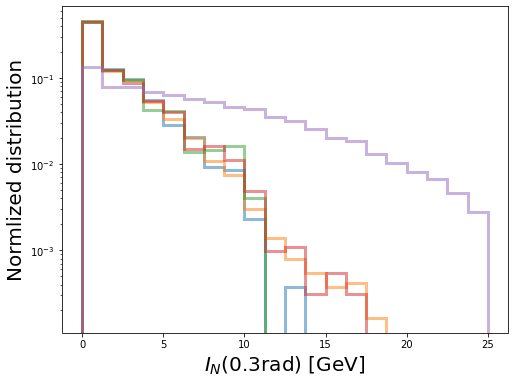

In [166]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,25]

# ax1.margins(y=0.3)

ax1.hist(df_plot[(df_plot.target==0)]['ENeutral03'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['ENeutral03'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==2)]['ENeutral03'], weights=df_plot[df_plot.target==2]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==3)]['ENeutral03'], weights=df_plot[df_plot.target==3]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['ENeutral03'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$I_N(0.3\rm rad)$ [GeV]', fontsize=20)
ax1.set_yticks([])
# ax1.legend(loc=1, fontsize=20)
ax1.set_yscale('log')

f.savefig('./figures/Dsisolation_logy')


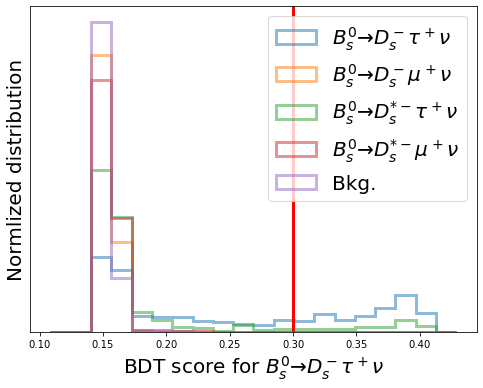

In [168]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
df_plot = df_bdt_test_s
pred0_max = df_plot[(df_plot.target==0)]['pred0'].max() 
pred0_min = df_plot[(df_plot.target==0)]['pred0'].min() 
pred0_diff = pred0_max - pred0_min
range_=[pred0_min - 0.1*pred0_max, pred0_max + 0.1*pred0_diff]


ax1.hist(df_plot[(df_plot.target==0)]['pred0'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['pred0'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==2)]['pred0'], weights=df_plot[df_plot.target==2]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==3)]['pred0'], weights=df_plot[df_plot.target==3]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['pred0'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'BDT score for $B_s^0\to D_s^- \tau^+\nu$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.axvline(c1, color='red', lw=3)

f.savefig('./figures/DstauBDT')


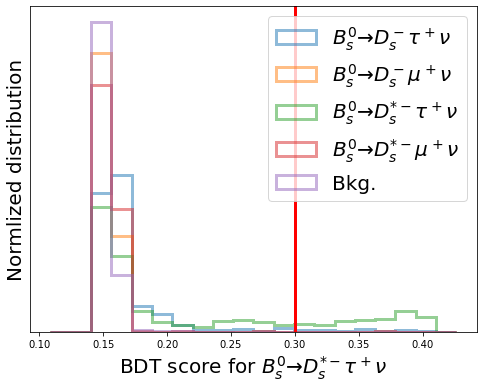

In [169]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
df_plot = df_bdt_test_s
pred0_max = df_plot[(df_plot.target==0)]['pred2'].max() 
pred0_min = df_plot[(df_plot.target==0)]['pred2'].min() 
pred0_diff = pred0_max - pred0_min
range_=[pred0_min - 0.1*pred0_max, pred0_max + 0.1*pred0_diff]


ax1.hist(df_plot[(df_plot.target==0)]['pred2'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['pred2'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==2)]['pred2'], weights=df_plot[df_plot.target==2]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==3)]['pred2'], weights=df_plot[df_plot.target==3]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['pred2'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'BDT score for $B_s^0\to D_s^{*-} \tau^+\nu$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.axvline(c1, color='red', lw=3)

f.savefig('./figures/DsstartauBDT')


In [62]:
d = xgbc1.get_booster().get_score()
dict(sorted(d.items(), key=lambda item: -1*item[1]))

{'DeltaM': 2263.0,
 'q2': 1997.0,
 'miss2': 1919.0,
 'pB': 1658.0,
 'sMinMuBVert': 1561.0,
 'mHcMu': 1256.0,
 'pHc': 1246.0,
 'pMu': 1207.0,
 'sPVHc': 1183.0,
 'sMinMuHcVert': 1119.0,
 'pPerp': 1117.0,
 'mCorr': 1099.0,
 'ENeutral06': 702.0,
 'ENeutral03': 666.0,
 'sMinHcTr': 553.0,
 'sMinMuTr': 535.0,
 'ENeutral06Photon': 480.0,
 'ECharge06': 466.0,
 'ECharge06PV': 460.0,
 'ENeutral03Photon': 404.0,
 'ENeutral06Hadron': 358.0,
 'ECharge03PV': 358.0,
 'ECharge03': 342.0,
 'ENeutral03Hadron': 288.0,
 'ECharge06DV': 212.0,
 'ECharge03DV': 200.0,
 'D0Max': 175.0,
 'DzMax': 169.0,
 'DzSum': 164.0,
 'EHc': 136.0,
 'D0Sum': 113.0}

In [63]:
df_plot0 = df_test.loc[df_bdt_test_s0_cut.index]
df_plot2 = df_test.loc[df_bdt_test_s2_cut.index]
# df_plot = df_test

[]

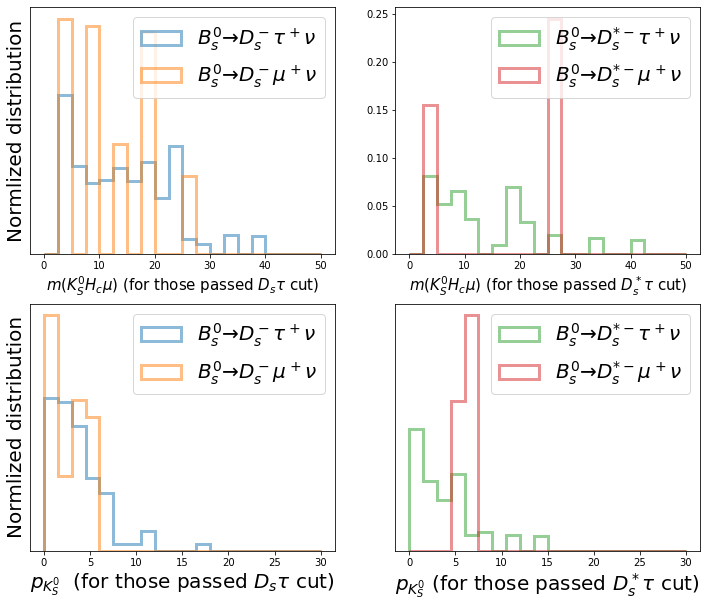

In [64]:
f = plt.figure(figsize=(12,10))
# ax1 = plt.subplot(111)
range_=[0, 50]

# ax1.margins(y=0.3)
bins_=20

# plt.
ax1 = plt.subplot(221)
ax1.hist(df_plot0[(df_plot0.target==0)]['mK0SHcMu'], weights=df_plot0[df_plot0.target==0]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5, color='C0');
ax1.hist(df_plot0[(df_plot0.target==1)]['mK0SHcMu'], weights=df_plot0[df_plot0.target==1]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5, color='C1');


ax2 = plt.subplot(222)
ax2.hist(df_plot2[(df_plot2.target==2)]['mK0SHcMu'], weights=df_plot2[df_plot2.target==2]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C2');
ax2.hist(df_plot2[(df_plot2.target==3)]['mK0SHcMu'], weights=df_plot2[df_plot2.target==3]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C3');
# ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['pK0S'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C4');


ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$m(K^0_S H_c \mu)$ (for those passed $D_s\tau$ cut)', fontsize=15)
ax2.set_xlabel(r'$m(K^0_S H_c \mu)$ (for those passed $D_s^* \tau$ cut)', fontsize=15)
ax1.set_yticks([])
ax3.set_yticks([])


range_=[0, 30]

ax3 = plt.subplot(223)
ax3.hist(df_plot0[(df_plot0.target==0)]['pK0S'], weights=df_plot0[df_plot0.target==0]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5, color='C0');
ax3.hist(df_plot0[(df_plot0.target==1)]['pK0S'], weights=df_plot0[df_plot0.target==1]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5, color='C1');


ax4 = plt.subplot(224)
ax4.hist(df_plot2[(df_plot2.target==2)]['pK0S'], weights=df_plot2[df_plot2.target==2]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C2');
ax4.hist(df_plot2[(df_plot2.target==3)]['pK0S'], weights=df_plot2[df_plot2.target==3]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C3');
# ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['pK0S'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C4');

ax1.legend(loc=1, fontsize=20)
ax2.legend(loc=1, fontsize=20)
ax3.legend(loc=1, fontsize=20)
ax4.legend(loc=1, fontsize=20)

ax3.set_ylabel('Normlized distribution', fontsize=20)
ax3.set_xlabel(r'$p_{K^0_S}$  (for those passed $D_s\tau$ cut)', fontsize=20)
ax4.set_xlabel(r'$p_{K^0_S}$ (for those passed $D_s^*\tau$ cut)', fontsize=20)
ax3.set_yticks([])
ax4.set_yticks([])

# f.savefig('./Lambdab_plot/LambdabpK0S')
# f.savefig('./Lambdab_plot/LambdabpK0S_20noise')


In [65]:
print("fraction of events that contains reconstructed K0s:")
print("Ds tau:  {:.2f}\nDs mu:   {:.2f}\nDs* tau: {:.2f}\nDs* mu:  {:.2f}\n".format(
    1-len(df_test[(df_test.target==0) & (df_test.pK0S.isna())]) / len(df_test[(df_test.target==0)]),\
    1-len(df_test[(df_test.target==1) & (df_test.pK0S.isna())]) / len(df_test[(df_test.target==1)]),\
    1-len(df_test[(df_test.target==2) & (df_test.pK0S.isna())]) / len(df_test[(df_test.target==2)]),\
    1-len(df_test[(df_test.target==3) & (df_test.pK0S.isna())]) / len(df_test[(df_test.target==3)])))

fraction of events that contains reconstructed K0s:
Ds tau:  1.00
Ds mu:   1.00
Ds* tau: 1.00
Ds* mu:  1.00



In [44]:
len(df_train_o[df_train_o.target==4]) + len(df_test_o[df_test_o.target==4])

2429